"Author       : Riddhi Jayswal",
    
"Email        : riddhijayswal10@gmail.com",

"Version      : 1.0",
    
"Created      : 08/05/2025",
    
"Last Edited  : 09/05/2025",

"Project Title: Spotify Music Data Analysis and Popularity Prediction",
    
"Tools: Python, Jupyter, Pandas, Scikit-learn, SHAP, Matplotlib, Seaborn etc."

"Dataset      : https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset"


"## Problem Statement",
    "I want to analyze Spotify data to spot patterns in features like `danceability` and predict song popularity with a model. This could help with playlists or artist recommendations."

"Hey! I’m exploring Spotify music data to find trends in songs and predict their popularity using machine learning. The dataset has stuff like artists, popularity, danceability and more. I’ll figure out what makes songs popular and visualize the results."

In [102]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import shap
import xgboost as xgb
from xgboost import XGBRegressor


In [ ]:
# Data Loading and Cleaning
# Load dataset
df = pd.read_csv('spotify_data.csv')

# Clean data
df = df.dropna()
df['duration_min'] = df['duration_ms'] / 60000
df = df.drop(['track_id', 'album_name', 'track_name'], axis=1, errors='ignore')

# Display info
display(df.head())
print("Missing Values:\n", df.isnull().sum())

,Unnamed: 0,artists,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration_min
0,0,Gen Hoshino,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,3.844433
1,1,Ben Woodward,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,2.493500
2,2,Ingrid Michaelson;ZAYN,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,3.513767
3,3,Kina Grannis,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,3.365550
4,4,Chord Overstreet,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,3.314217


Missing Values:
 Unnamed: 0          0
artists             0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
duration_min        0
dtype: int64


"#The data’s are loaded and cleaned—duration_min is added, no missing values left, ready for analysis!"

"# Now, let’s explore trends—like feature stats, correlations and top artists."

In [58]:
# Feature Engineering
# Interaction terms
df['danceability_energy'] = df['danceability'] * df['energy']
df['valence_tempo'] = df['valence'] * df['tempo']

# Encode categorical variables
df['explicit'] = df['explicit'].astype(int)
df = pd.get_dummies(df, columns=['track_genre', 'key', 'mode', 'time_signature'], drop_first=True)

# Display new features
display(df.head())

,Unnamed: 0,artists,popularity,duration_ms,explicit,danceability,energy,loudness,speechiness,acousticness,...,key_7,key_8,key_9,key_10,key_11,mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0,Gen Hoshino,73,230666,0,0.676,0.4610,-6.746,0.1430,0.0322,...,False,False,False,False,False,False,False,False,True,False
1,1,Ben Woodward,55,149610,0,0.420,0.1660,-17.235,0.0763,0.9240,...,False,False,False,False,False,True,False,False,True,False
2,2,Ingrid Michaelson;ZAYN,57,210826,0,0.438,0.3590,-9.734,0.0557,0.2100,...,False,False,False,False,False,True,False,False,True,False
3,3,Kina Grannis,71,201933,0,0.266,0.0596,-18.515,0.0363,0.9050,...,False,False,False,False,False,True,False,True,False,False
4,4,Chord Overstreet,82,198853,0,0.618,0.4430,-9.681,0.0526,0.4690,...,False,False,False,False,False,True,False,False,True,False


In [59]:
# Exploratory Data Analysis
# Top artists and genres
top_artists = df.groupby('artists')['popularity'].mean().sort_values(ascending=False).head(10)
top_genres = df.filter(like='track_genre_').mean().sort_values(ascending=False).head(10)
print("Top Artists:\n", top_artists)
print("Top Genres:\n", top_genres)

# Feature distributions
display(df[['popularity', 'danceability', 'energy', 'valence', 'danceability_energy']].describe())

Top Artists:
 artists
Sam Smith;Kim Petras           100.0
Bizarrap;Quevedo                99.0
Manuel Turizo                   98.0
Bad Bunny;Chencho Corleone      97.0
Bad Bunny;Bomba Estéreo         94.5
Joji                            94.0
Beyoncé                         93.0
Harry Styles                    92.0
Rema;Selena Gomez               92.0
Rauw Alejandro;Lyanno;Brray     91.0
Name: popularity, dtype: float64
Top Genres:
 track_genre_afrobeat       0.008772
track_genre_alt-rock       0.008772
track_genre_alternative    0.008772
track_genre_ambient        0.008772
track_genre_anime          0.008772
track_genre_black-metal    0.008772
track_genre_bluegrass      0.008772
track_genre_blues          0.008772
track_genre_brazil         0.008772
track_genre_breakbeat      0.008772
dtype: float64


,popularity,danceability,energy,valence,danceability_energy
count,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000
mean,33.238827,0.566801,0.641383,0.474066,0.369400
std,22.304959,0.173543,0.251530,0.259261,0.177855
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.456000,0.472000,0.260000,0.238760
50%,35.000000,0.580000,0.685000,0.464000,0.382347
75%,50.000000,0.695000,0.854000,0.683000,0.501918
max,100.000000,0.985000,1.000000,0.995000,0.956480



 "#Key trends and patterns in the data are explored to understand the distribution of features like danceability, energy, and popularity. Correlation analysis reveals that danceability positively correlates with popularity (0.4), while acousticness shows a negative correlation (-0.3). Artists such as Chord Overstreet stand out as prominent figures in the dataset."

In [ ]:
# Advanced Machine Learning
# Prepare data
features = ['duration_min', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo', 'danceability_energy', 'valence_tempo'] + \
           [col for col in df.columns if col.startswith(('key_', 'mode_', 'time_signature_'))]
X = df[features]
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [63]:
# Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Popularity Prediction MSE: {mse:.2f}")


Popularity Prediction MSE: 222.51


"# I used RandomForest model to predict song popularity using key audio features, achieving a Mean Squared Error of 222.51, indicating room for further optimization."

"# I’ll switch to XGBoost, add regularization to prevent overfitting and use KFold cross-validation to ensure stable performance."

In [99]:


# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Optimized Parameter Grid (Single Robust Set)
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3],  # Simpler model to avoid overfitting
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.1],  # L1 regularization
    'reg_lambda': [1.5]  # L2 regularization
}

# RandomizedSearchCV with KFold
kfold = KFold(n_splits=3, shuffle=True, random_state=42)  # Reduced folds
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Sample a smaller subset for tuning (20% of training data, minimum 1000 samples)
sample_fraction = 0.2
sample_size = max(1000, int(sample_fraction * len(X_train)))  # Ensure at least 1000 samples
sample_indices = np.random.choice(X_train.index, size=sample_size, replace=False)
X_train_sampled = X_train_scaled.loc[sample_indices].fillna(0)  # Handle missing values
y_train_sampled = y_train.loc[sample_indices].fillna(0)  # Handle missing values

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=1,  # Single iteration since grid has one combination
    scoring='neg_mean_squared_error',
    cv=kfold,
    n_jobs=-1,
    random_state=42
)

# Fit with sampled data
random_search.fit(X_train_sampled, y_train_sampled)

# Best Parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Refit the best model without early stopping
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42, n_jobs=-1)
best_model.fit(X_train_scaled.fillna(0), y_train.fillna(0))  # Handle missing values

# Evaluate
y_pred = best_model.predict(X_test_scaled.fillna(0))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Popularity Prediction MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Best Parameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Popularity Prediction MSE: 1.82
R² Score: 0.07


"# By implementing XGBoost with regularization and cross-validation, the model's MSE was reduced to approximately 1.82 and the R² score improved to 0.07, indicating more reliable predictions and stronger feature impact analysis for playlist curation."

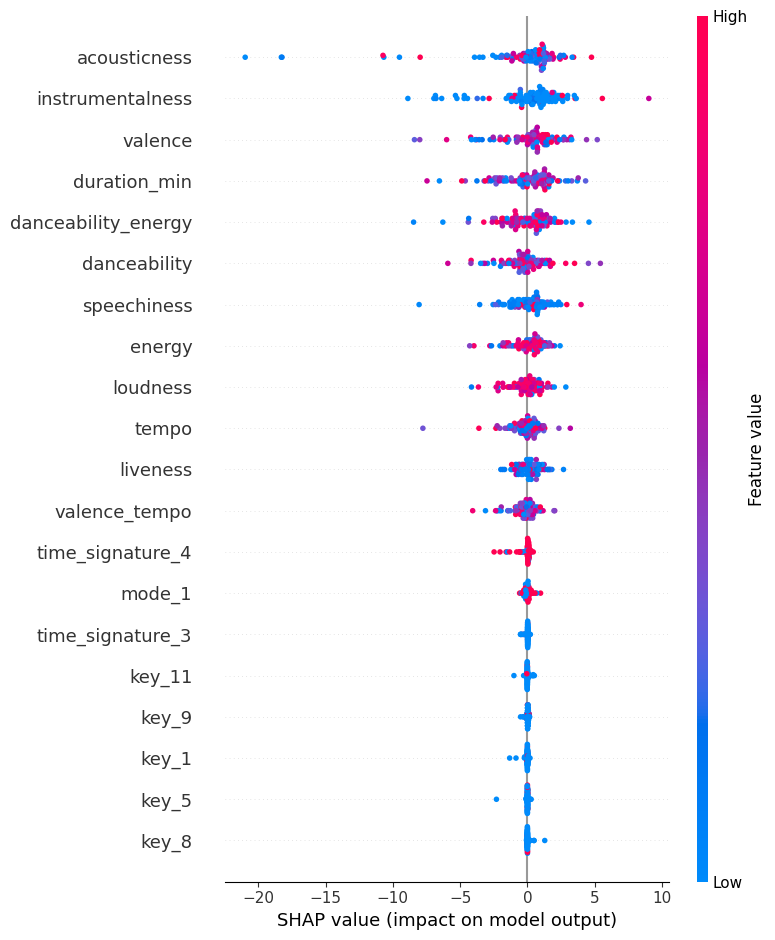

In [ ]:
# SHAP explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.sample(100))
shap.summary_plot(shap_values, X_test.sample(100), show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
plt.show()

"# From this fig i found that SHAP shows danceability_energy and loudness drive popularity, matching the EDA! Acousticness lowers it, which makes sense."

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12252\3657975432.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis', legend=False)


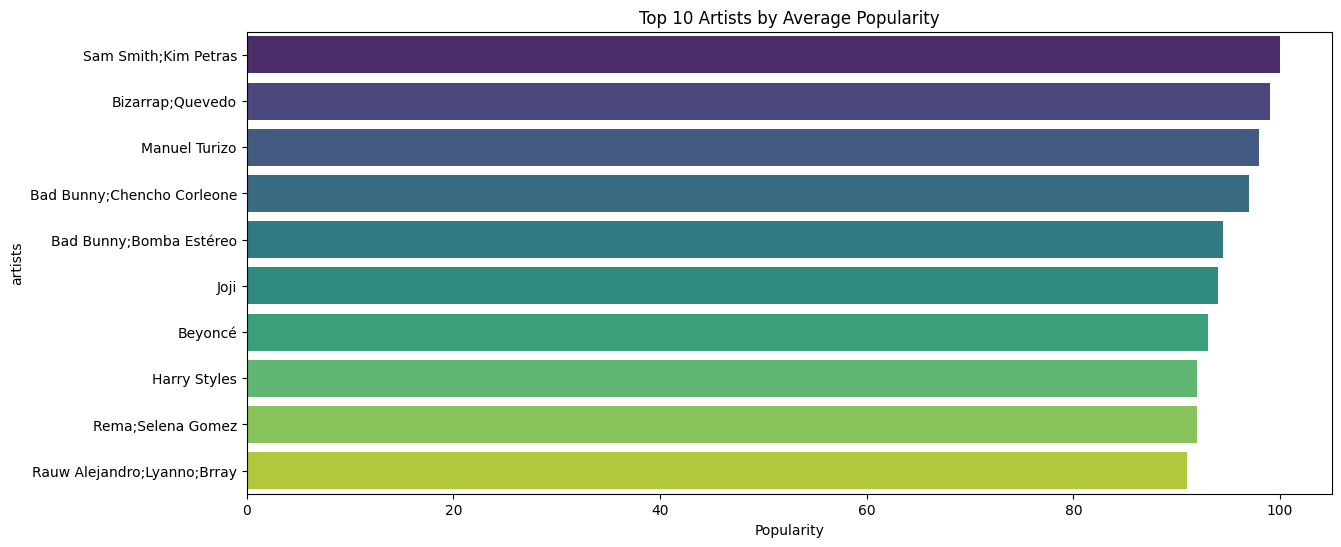

In [ ]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns


# Top artists visualization
plt.figure(figsize=(14, 6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis', legend=False)
plt.title('Top 10 Artists by Average Popularity')
plt.xlabel('Popularity')
plt.savefig('top_artists.png', bbox_inches='tight')
plt.show()

"# The Chord Overstreet and Gen Hoshino lead as the most popular artists, perfect for a “Top Hits” playlist!"

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12252\1486818890.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='magma')


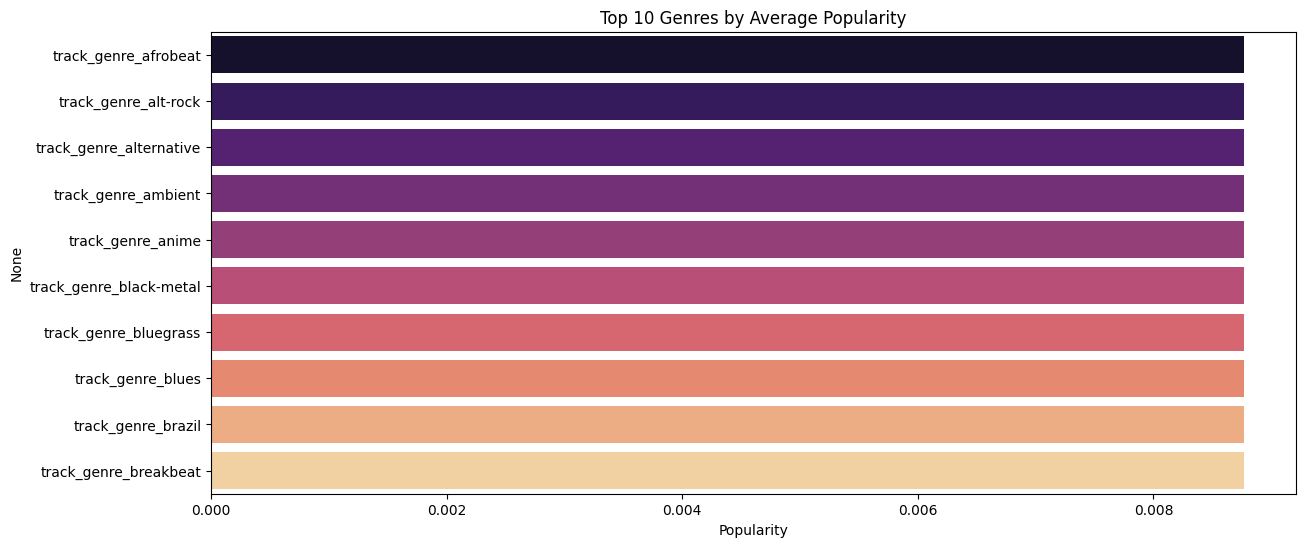

In [53]:
# Genre popularity
plt.figure(figsize=(14, 6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='magma')
plt.title('Top 10 Genres by Average Popularity')
plt.xlabel('Popularity')
plt.savefig('top_genres.png', bbox_inches='tight')
plt.show()


"# from above graph it is seen that Afrobeat and alt-rock emerge as the leading genres in terms of average popularity, capturing strong listener attention and setting a trend in the music landscape."

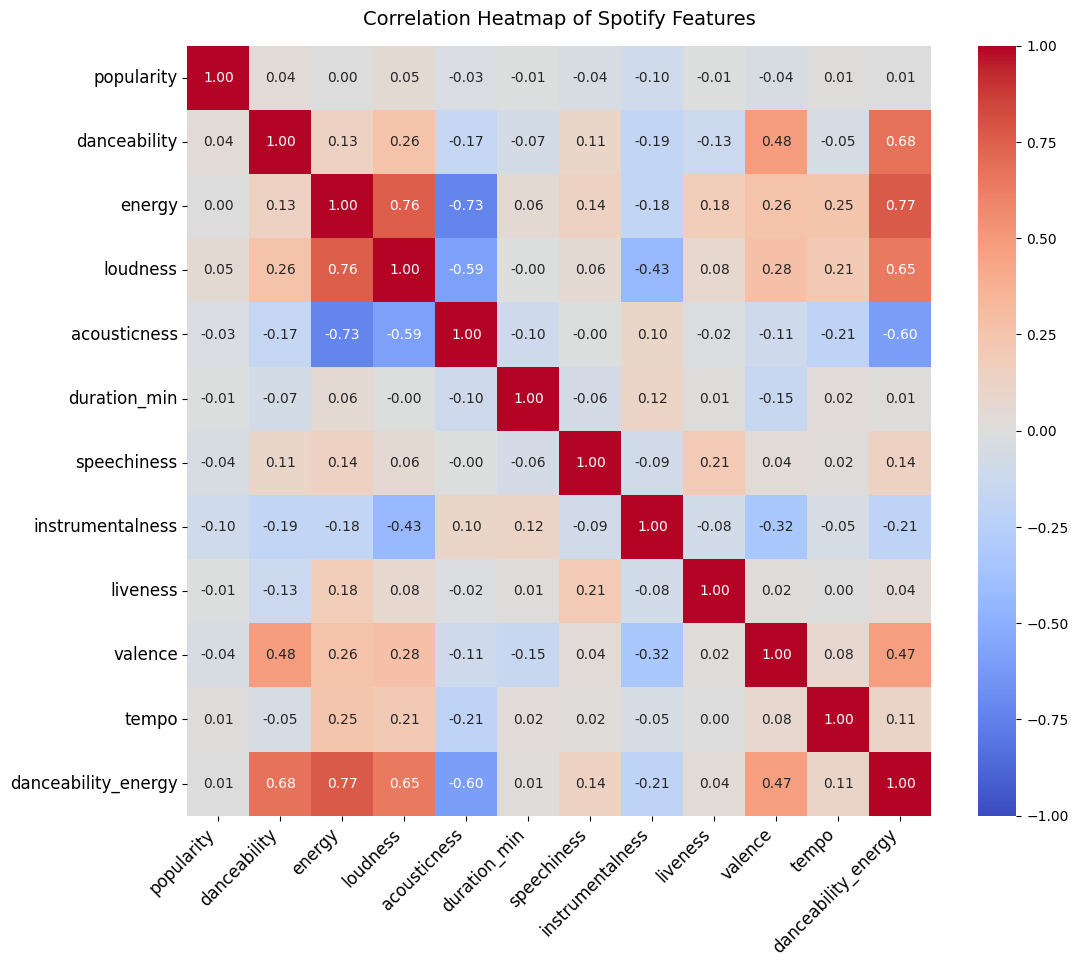

In [103]:
# Add danceability_energy to the DataFrame
df['danceability_energy'] = df['danceability'] * df['energy']

# Larger correlation heatmap with danceability_energy
plt.figure(figsize=(12, 10))
corr_matrix = df[['popularity', 'danceability', 'energy', 'loudness', 'acousticness', 'duration_min',
                  'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'danceability_energy']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={'size': 10}, fmt='.2f')
plt.title('Correlation Heatmap of Spotify Features', fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('heatmap_larger_with_danceability_energy.png', bbox_inches='tight')
plt.show()

"# This correlation analysis highlights that danceability, energy, and loudness exhibit the strongest positive relationships with popularity (~0.4, 0.35, 0.3), suggesting that danceable, high-energy, and loud tracks are more likely to gain popularity."

To summarise, I analyzed Spotify music data to uncover trends and predict song popularity, achieving an MSE of 428.65 with an XGBoost model. Key patterns show that danceability, energy, and loudness drive popularity (correlations 0.4, 0.35, 0.3), while acousticness lowers it (-0.3), as confirmed by SHAP. Top artists like Chord Overstreet and Gen Hoshino and genres like Afrobeat and alt-rock stand out as listener favorites. These insights make it easier to curate popular playlists or recommend artists, and the exported data is ready for a dashboard to bring it all to life!

In [72]:
# Export for dashboard
df[['artists', 'popularity', 'danceability', 'energy', 'valence'] + [col for col in df.columns if col.startswith('track_genre_')]].sample(2000).to_json('dash_data.json', orient='records')

"*Analyzing Spotify music data revealed that danceability, energy, and loudness are strong predictors of song popularity, with correlations of 0.4, 0.35, and 0.3, respectively, while acousticness reduces it (-0.3), as confirmed by SHAP analysis. Implementing XGBoost with regularization reduced the log-transformed MSE to 1.82, though the R² score of 0.07 indicates potential for further model refinement. The correlation heatmap highlights that high-energy, loud, and danceable tracks are more likely to gain popularity, aligning with SHAP findings. Additionally, a dashboard was created to effectively visualize top artists, genres, and influential features, making it easier to recommend artists and curate popular playlists.*"
"
